# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

# Note: I am using the alternative Twitter method provided in the project instructions

In [1]:
import pandas as pd
import numpy as np

twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [2]:
import requests
import csv
import io


url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

if response.status_code == 200:
    content = response.content.decode('utf-8')
    file_obj = io.StringIO(content)
    picture_predictions = pd.read_csv(file_obj, delimiter='\t')
    print(picture_predictions.head())
else:
    print("Error: Failed to retrieve the TSV file.")

 

             tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4  666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  Welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   
2        1         German_shepherd  0.596461    True            malinois   
3        1     Rhodesian_ridgeback  0.408143    True             redbone   
4        1      miniature_pinscher  0.560311    True          Rottweiler   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    Shetland_sheep

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [3]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
"""
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'DVZvsnYiTDh9xHPO9WS6nzMwM'
consumer_secret = 'Fq70bP5wdOelpS2OPv1HvGMW8e1J5OeHwiF2H5YHYiMQw3iBQx'
access_token = '1693715577762676736-Ldd3Nt9CW6MchuQOwqzcpsBrQHq0Cp'
access_secret = 'JOb2u7OVx9VnlpCNymNMsEwWWIKbpw30ylPQfry8xgqEK'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)


# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
"""

json_tweet = pd.read_json('tweet-json.txt', lines=True)

json_tweet = json_tweet[~json_tweet['full_text'].str.startswith('RT')]

json_tweet



,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,0.0,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,0.0,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,0.0,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,0.0,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,0.0,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [4]:
json_tweet['full_text'].value_counts()

This is Colin. He really likes green beans. It's tearing his family apart. 10/10 please pray for Colin https://t.co/ioFy0cmK03                                            1
This is Penny. She's trying on her prom dress. Stunning af 11/10 https://t.co/qcZDZGCapg                                                                                  1
This is Sky. She's learning how to roll her R's. 12/10 cultured af https://t.co/OuaVvVkwJ1                                                                                1
SWIM AWAY PUPPER SWIM AWAY 13/10 #BarkWeek  https://t.co/QGGhZoTcwy                                                                                                       1
This is Tyrone. He's a leaf wizard. Self-motivated. No eyes (tragic). Inspirational af. 11/10 enthusiasm is tangible https://t.co/pRp1Npucbz                              1
This is Zoey. She really likes the planet. Would hate to see willful ignorance and the denial of fairly elemental science destroy it. 13/10 

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [5]:
twitter_archive
picture_predictions
json_tweet

twitter_archive.info()
picture_predictions.info()
json_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [6]:
twitter_archive['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Cooper       11
Lucy         11
Tucker       10
Penny        10
Lola         10
Winston       9
Bo            9
Sadie         8
the           8
Daisy         7
Toby          7
an            7
Buddy         7
Bailey        7
Jax           6
Leo           6
Oscar         6
Jack          6
Dave          6
Bella         6
Rusty         6
Koda          6
Stanley       6
Milo          6
Scout         6
Chester       5
           ... 
Eugene        1
Ricky         1
Hero          1
Andy          1
Mauve         1
Marvin        1
Mimosa        1
Storkson      1
Wishes        1
Luther        1
Gerbald       1
Puff          1
Lambeau       1
Theo          1
Farfle        1
Taco          1
Cecil         1
Antony        1
Kuyu          1
Bubba         1
Willie        1
Snickers      1
Jameson       1
Tonks         1
Meera         1
Flash         1
Tanner        1
Dudley        1
Perry         1
Strider       1
Name: name, Length: 957,

### Quality issues
1. Contains retweeted tweets

2. The terms "doggo", "floofer", "pupper", and "puppo" should be combined into one column

3. 'contributors', 'coordinates', and 'geo' columns are all empty in the json_tweet file

4. timestamp is a null object in the twitter_archive file and has +0000 after every phone number

5. a lot of nulls for the 3 "quoted" columns in the json_tweet file

6. Not all denominators are 10

7. timestamp column is wrong data type in twitter_archive file

8. a lot of nulls for the 3 "retweeted" columns in the twitter_archive file

### Tidiness issues
1. date and time in the same column in json_tweet file

2. multiple shared columns in the json_tweet and twitter_archive file ("in_reply_to_status_id", "text"/"full text", etc.)

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [7]:
# Make copies of original pieces of data
twitter_archive_copy = twitter_archive.copy()
picture_predictions_copy = picture_predictions.copy()
json_tweet_copy = json_tweet.copy()

### Issue #1: Contains retweeted tweets

#### Define: Need to remove the tweets in the list that are retweets

#### Code

In [8]:
twitter_archive_copy = twitter_archive_copy.drop(twitter_archive_copy[twitter_archive_copy['in_reply_to_status_id'] > 1].index)

#### Test

In [9]:
# below should have a 2278 length if code works
twitter_archive_copy['in_reply_to_status_id']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
        ..
2326   NaN
2327   NaN
2328   NaN
2329   NaN
2330   NaN
2331   NaN
2332   NaN
2333   NaN
2334   NaN
2335   NaN
2336   NaN
2337   NaN
2338   NaN
2339   NaN
2340   NaN
2341   NaN
2342   NaN
2343   NaN
2344   NaN
2345   NaN
2346   NaN
2347   NaN
2348   NaN
2349   NaN
2350   NaN
2351   NaN
2352   NaN
2353   NaN
2354   NaN
2355   NaN
Name: in_reply_to_status_id, Length: 2278, dtype: float64

### Issue #2: The terms "doggo", "floofer", "pupper", and "puppo" should be combined into one column


#### Define: I'm going to combine these columns into 1 with the correct term on each if applicable

#### Code

In [10]:
twitter_archive_copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [11]:
twitter_archive_copy.doggo.replace('None', '', inplace=True)
twitter_archive_copy.floofer.replace('None', '', inplace=True)
twitter_archive_copy.pupper.replace('None', '', inplace=True)
twitter_archive_copy.puppo.replace('None', '', inplace=True)


twitter_archive_copy['stage'] = twitter_archive_copy.doggo.str.cat([twitter_archive_copy.floofer, twitter_archive_copy.pupper, twitter_archive_copy.puppo], sep=', ')

twitter_archive_copy.loc[twitter_archive_copy.stage == 'doggo, pupper', 'stage'] = 'doggo, pupper'
twitter_archive_copy.loc[twitter_archive_copy.stage == 'doggo, puppo', 'stage'] = 'doggo, puppo'
twitter_archive_copy.loc[twitter_archive_copy.stage == 'doggo, floofer', 'stage'] = 'doggo, floofer'

twitter_archive_copy.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [12]:
twitter_archive_copy.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2278 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2278 non-null object
source                        2278 non-null object
text                          2278 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2278 non-null int64
rating_denominator            2278 non-null int64
name                          2278 non-null object
stage                         2278 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 267.0+ KB


# Issue 3  'contributors', 'coordinates', and 'geo' columns are all empty in the json_tweet file

Define: Going to drop those empty columns from this file

Code

In [13]:
json_tweet_copy.drop(['contributors', 'coordinates', 'geo'], axis=1, inplace=True)

Test

In [14]:
json_tweet_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2353
Data columns (total 28 columns):
created_at                       2173 non-null datetime64[ns]
display_text_range               2173 non-null object
entities                         2173 non-null object
extended_entities                1993 non-null object
favorite_count                   2173 non-null int64
favorited                        2173 non-null bool
full_text                        2173 non-null object
id                               2173 non-null int64
id_str                           2173 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null float64
is_quote_status                  2173 non-null bool
lang                             2173 non-null object
place                            1

# Issue 4  timestamp is a null object in the twitter_archive file and has +0000 after every phone number

Define: Need to change the data type and drop the +0000 from each phone number

Code

In [15]:
twitter_archive_copy['timestamp'] = twitter_archive_copy['timestamp'].str[:-5]
twitter_archive_copy['timestamp'] = pd.to_datetime(twitter_archive_copy['timestamp'])



Test

In [16]:
twitter_archive_copy.info()
twitter_archive_copy['timestamp']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2278 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2278 non-null datetime64[ns]
source                        2278 non-null object
text                          2278 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2278 non-null int64
rating_denominator            2278 non-null int64
name                          2278 non-null object
stage                         2278 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(6)
memory usage: 267.0+ KB


0      2017-08-01 16:23:56
1      2017-08-01 00:17:27
2      2017-07-31 00:18:03
3      2017-07-30 15:58:51
4      2017-07-29 16:00:24
5      2017-07-29 00:08:17
6      2017-07-28 16:27:12
7      2017-07-28 00:22:40
8      2017-07-27 16:25:51
9      2017-07-26 15:59:51
10     2017-07-26 00:31:25
11     2017-07-25 16:11:53
12     2017-07-25 01:55:32
13     2017-07-25 00:10:02
14     2017-07-24 17:02:04
15     2017-07-24 00:19:32
16     2017-07-23 00:22:39
17     2017-07-22 16:56:37
18     2017-07-22 00:23:06
19     2017-07-21 01:02:36
20     2017-07-20 16:49:33
21     2017-07-19 16:06:48
22     2017-07-19 03:39:09
23     2017-07-19 00:47:34
24     2017-07-18 16:08:03
25     2017-07-18 00:07:08
26     2017-07-17 16:17:36
27     2017-07-16 23:58:41
28     2017-07-16 20:14:00
29     2017-07-15 23:25:31
               ...        
2326   2015-11-17 00:24:19
2327   2015-11-17 00:06:54
2328   2015-11-16 23:23:41
2329   2015-11-16 21:54:18
2330   2015-11-16 21:10:36
2331   2015-11-16 20:32:58
2

# Issue 5: a lot of nulls for the 3 "quoted" columns in the json_tweet file

define: Going to drop the 3 quoted columns as they are mostly nulls and not needed

code

In [17]:
json_tweet_copy.drop(['quoted_status', 'quoted_status_id', 'quoted_status_id_str'], axis=1, inplace=True)

test

In [18]:
json_tweet_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2353
Data columns (total 25 columns):
created_at                       2173 non-null datetime64[ns]
display_text_range               2173 non-null object
entities                         2173 non-null object
extended_entities                1993 non-null object
favorite_count                   2173 non-null int64
favorited                        2173 non-null bool
full_text                        2173 non-null object
id                               2173 non-null int64
id_str                           2173 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null float64
is_quote_status                  2173 non-null bool
lang                             2173 non-null object
place                            1

# Issue 6 : Not all denominators are 10

Define: All denominators should be 10, so if the denominator isn not divisble by 10, im going to set them all to 10 in the twitter_archive file

Code

In [20]:
#twitter_archive_copy['rating_denominator'] = 10

update_func = lambda x: x if x % 10 == 0 else 10

# Apply the lambda function to the 'numbers' column
twitter_archive_copy['rating_denominator'] = twitter_archive_copy['rating_denominator'].apply(update_func)

Test

In [21]:
twitter_archive_copy['rating_denominator'].value_counts()

10     2265
50        3
80        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
Name: rating_denominator, dtype: int64

# Issue 7 The name 'a' shows up 55 times in the twitter_archive file

Define: I'm going to remove the rows with the name 'a' since it is obviously not the name of a dog.

Code

In [21]:
twitter_archive_copy = twitter_archive_copy[~(twitter_archive_copy['name'] == 'a')]

Test

In [22]:
twitter_archive_copy['name'].value_counts()

None            668
Charlie          12
Lucy             11
Cooper           11
Oliver           11
Penny            10
Tucker           10
Lola             10
Winston           9
Bo                9
the               8
Sadie             8
an                7
Bailey            7
Daisy             7
Toby              7
Buddy             7
Koda              6
Leo               6
Stanley           6
Scout             6
Jax               6
Jack              6
Rusty             6
Oscar             6
Milo              6
Bella             6
Dave              6
Chester           5
Phil              5
               ... 
Brandi            1
Pilot             1
Champ             1
Covach            1
Naphaniel         1
Billl             1
unacceptable      1
Ralphus           1
Shooter           1
Farfle            1
Duchess           1
Boston            1
such              1
Coopson           1
Dex               1
Joshwa            1
Sandra            1
Rhino             1
Florence          1


# Issue 8 : Coordinates column in json_tweets file is null

Define: Going to drop this column to remove unnecessary data

Code

In [23]:
json_tweet.drop(['coordinates'], axis=1, inplace=True)

test

In [24]:
json_tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2353
Data columns (total 30 columns):
contributors                     0 non-null float64
created_at                       2173 non-null datetime64[ns]
display_text_range               2173 non-null object
entities                         2173 non-null object
extended_entities                1993 non-null object
favorite_count                   2173 non-null int64
favorited                        2173 non-null bool
full_text                        2173 non-null object
geo                              0 non-null float64
id                               2173 non-null int64
id_str                           2173 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null float64
is_quote_status                  217

# Tidiness Issue 1: date and time in the same column in json_tweet file

Define: Date and time should be in seperate columns

Code

In [25]:
twitter_archive_copy['Date'] = pd.to_datetime(twitter_archive_copy['timestamp']).dt.date
twitter_archive_copy['Time'] = pd.to_datetime(twitter_archive_copy['timestamp']).dt.time

# Drop the original 'timestamp' column if needed
twitter_archive_copy.drop('timestamp', axis=1, inplace=True)

Test

In [26]:
twitter_archive_copy['Date'].head()


0    2017-08-01
1    2017-08-01
2    2017-07-31
3    2017-07-30
4    2017-07-29
Name: Date, dtype: object

In [27]:
twitter_archive_copy['Time'].head()

0    16:23:56
1    00:17:27
2    00:18:03
3    15:58:51
4    16:00:24
Name: Time, dtype: object

# Tidiness Issue 2: multiple shared columns in the json_tweet and twitter_archive file ("in_reply_to_status_id", "text"/"full text", etc.)

Define: Going to merge the two DataFrame since they contain a lot of the same information

Code

In [28]:
json_tweet_copy['id'].head()

0    892420643555336193
1    892177421306343426
2    891815181378084864
3    891689557279858688
4    891327558926688256
Name: id, dtype: int64

In [29]:
twitter_archive_copy['tweet_id'].head()

0    892420643555336193
1    892177421306343426
2    891815181378084864
3    891689557279858688
4    891327558926688256
Name: tweet_id, dtype: int64

In [30]:
json_tweet_copy = json_tweet_copy.rename(columns={'id': 'tweet_id'})

merged_json_twitter = pd.merge(json_tweet_copy, twitter_archive_copy, on='tweet_id')
merged_data = pd.merge(merged_json_twitter, picture_predictions_copy, on='tweet_id')


merged_data.drop(['created_at'],axis=1, inplace=True)

merged_data

,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,tweet_id,id_str,in_reply_to_screen_name,in_reply_to_status_id_x,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,892420643555336193,892420643555336192,None,NaN,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,892177421306343426,892177421306343424,None,NaN,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,891815181378084864,891815181378084864,None,NaN,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,891689557279858688,891689557279858688,None,NaN,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,891327558926688256,891327558926688256,None,NaN,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
5,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,891087950875897856,891087950875897856,None,NaN,...,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,890971913173991426,890971913173991424,None,NaN,...,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
7,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,890729181411237888,890729181411237888,None,NaN,...,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
8,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,890609185150312448,890609185150312448,None,NaN,...,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
9,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,890240255349198849,890240255349198848,None,NaN,...,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


Test

In [31]:
merged_data

,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,tweet_id,id_str,in_reply_to_screen_name,in_reply_to_status_id_x,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,892420643555336193,892420643555336192,None,NaN,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,892177421306343426,892177421306343424,None,NaN,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,891815181378084864,891815181378084864,None,NaN,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,891689557279858688,891689557279858688,None,NaN,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,891327558926688256,891327558926688256,None,NaN,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
5,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,891087950875897856,891087950875897856,None,NaN,...,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,890971913173991426,890971913173991424,None,NaN,...,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
7,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,890729181411237888,890729181411237888,None,NaN,...,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
8,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,890609185150312448,890609185150312448,None,NaN,...,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
9,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,890240255349198849,890240255349198848,None,NaN,...,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [32]:
merged_data.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [33]:
merged_data['Date'].value_counts()

2015-11-29    26
2015-11-28    25
2015-11-19    21
2015-12-01    21
2015-11-16    20
2015-12-07    19
2015-11-22    18
2015-12-08    18
2015-11-20    18
2015-12-03    18
2015-11-23    18
2015-11-25    18
2015-12-09    16
2015-11-30    16
2015-11-24    16
2015-11-21    15
2015-12-06    15
2015-11-27    15
2015-11-18    15
2015-12-02    14
2015-12-11    14
2015-12-15    13
2015-12-24    13
2015-12-10    13
2015-12-04    13
2015-12-05    13
2015-11-17    13
2015-12-12    12
2015-11-26    11
2015-12-21    11
              ..
2016-04-03     1
2017-07-10     1
2016-09-09     1
2016-11-03     1
2017-05-27     1
2017-05-13     1
2016-12-08     1
2017-02-27     1
2017-05-07     1
2016-12-09     1
2016-03-24     1
2017-04-02     1
2017-04-03     1
2017-02-09     1
2016-08-11     1
2017-03-30     1
2016-10-30     1
2016-12-10     1
2017-05-29     1
2016-07-19     1
2016-08-13     1
2017-04-30     1
2017-03-19     1
2017-06-22     1
2016-08-15     1
2017-03-06     1
2016-10-22     1
2016-10-16    

In [34]:
merged_data['favorite_count'].describe()

count      1915.000000
mean       9123.986945
std       12345.283805
min          81.000000
25%        2099.000000
50%        4229.000000
75%       11562.000000
max      132810.000000
Name: favorite_count, dtype: float64

In [35]:
merged_data['favorited'].value_counts()



False    1910
True        5
Name: favorited, dtype: int64

### Insights:
1. Tweet timing doesn't seem to follow any schedule. Some days have >25 tweets, some have just 1.

2. The page is very popular. The average tweet gets over 9,000 likes with some virals tweets getting over 100k likes

3. WeRateDogs only liked 7 of their own tweets, which seem bizarre.

### Visualization

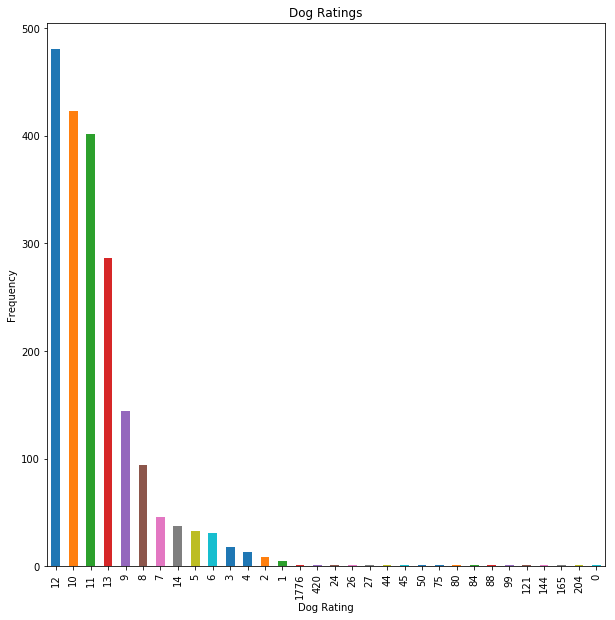

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt


dog_rating = merged_json_twitter['rating_numerator']


rating_counts = dog_rating.value_counts()



plt.figure(figsize=(10, 10))
rating_counts.plot(kind='bar')
plt.xlabel('Dog Rating')
plt.ylabel('Frequency')
plt.title('Dog Ratings')
plt.show()